In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Common imports
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import time

In [2]:
BATCH_SIZE = 32

# Etude 2 - Training a VAE

Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples.

Let's use the "Labeled Faces in the Wild" dataset.

In [3]:
dataset, dataset_info = tfds.load("lfw:0.*.*", with_info=True)

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [5]:
ds_train = tfds.load("lfw:0.1.*", split='train')

Let's create a validation dataset.

In [6]:
def calculate_dataset_size(dataset):
    """Returns the dataset length."""
    item_count = 0
    for item in dataset:
        item_count += 1
    return item_count

In [7]:
ds_train_size = calculate_dataset_size(ds_train)
ds_validation_size = int(0.15 * ds_train_size)

In [8]:
ds_valid = ds_train.take(ds_validation_size)

Since this dataset does not support a supervised (input, label) structure, we will create it manually; otherwise, we may encounter issues described in https://github.com/tensorflow/tensorflow/issues/35925.

In [9]:
# using just (x['image']) leads to the "WARNING:tensorflow:Gradients do not exist for variables"
ds_train = ds_train.map(lambda x: (x['image'], x['image']), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.map(lambda x: (x['image'], x['image']), num_parallel_calls=tf.data.experimental.AUTOTUNE)

Let's visualize some of the dataset images.

In [10]:
def visualize_dataset(dataset):
    """Visualizes several dataset images."""
    plt.figure(figsize=(12, 6))
    index = 0
    for item in dataset.take(6):
        index += 1
        plt.subplot(2, 3, index)
        plt.imshow(item[0])
        plt.axis("off")
    plt.show()

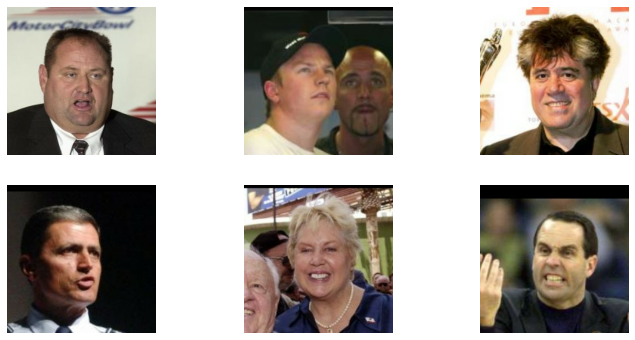

In [11]:
visualize_dataset(ds_train)

Let's determine what is the smallest images' height and width in the dataset. We will use this information to determine the paratemeters of the image crop.

In [12]:
def determine_minimum_dimensions(dataset, dataset_length):
    """Determines the largest height and width of the image in the dataset."""
    height = []
    width = []
    for item in dataset.take(dataset_length):
        height.append(item[0].shape[0])
        width.append(item[0].shape[1])        
    return  min(height), min(width)

In [13]:
image_h, image_w =  determine_minimum_dimensions(ds_train, ds_train_size)

In [14]:
print(f"Smallest height: {image_h}\nSmallest width: {image_w}")

Smallest height: 250
Smallest width: 250


In [15]:
target_image_dim = min(image_h, image_w)
resized_image_dim = target_image_dim // 2 + 3

Let's resize and preprocess the images.

In [16]:
def normalize_image(image):
    """Normalizes the image."""
    normalized_image = tf.cast(image, tf.float32) / 255.0
    return normalized_image

def resize_image(image):
    """Resizes and pads the image."""
    # adding 
    resized_image = tf.image.resize_with_pad(image, resized_image_dim, resized_image_dim)
    return resized_image

def preprocess_image(image, target_image):
    resized_image = resize_image(image)
    resized_normalized_image = normalize_image(resized_image)
    return resized_normalized_image, resized_normalized_image

In [17]:
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)
ds_valid = ds_valid.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)

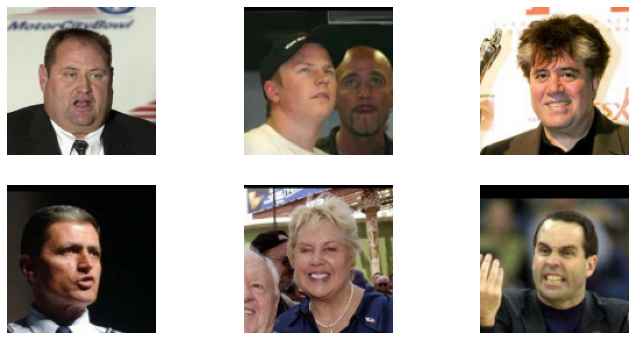

In [18]:
visualize_dataset(ds_train)

Now let's build a variational convolutional autoencoder. First, let's create a simple custom layer that would sample from the codings.

In [19]:
class Sampling(keras.layers.Layer):
    """"Samples from the codings using the specified mean and log_var."""
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var), mean, stddev=tf.math.exp(log_var / 2))

Let's create an encoder and decoder. The length of the coding vector will be quite small - only 10 values.

In [20]:
codings_size = 12

# CNN encoder
inputs = keras.layers.Input(shape=[resized_image_dim, resized_image_dim, 3])
z = keras.layers.Conv2D(filters=64, kernel_size=2, strides=2, padding="same", activation='relu')(inputs)
z = keras.layers.Conv2D(filters=128, kernel_size=2, strides=2, padding="same", activation='relu')(z)
z = keras.layers.Conv2D(filters=256, kernel_size=2, strides=2, padding="same", activation='relu')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings])

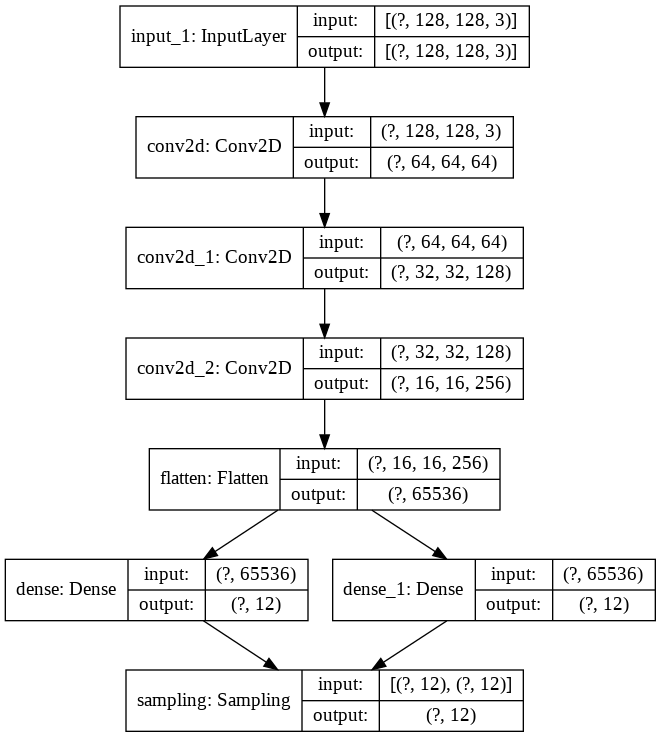

In [21]:
keras.utils.plot_model(variational_encoder, show_shapes=True)

In [22]:
# CNN decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
# without the next dense layer, the reshape is impossible,
# since then we are trying to reshape from the lower to a higher number of paremeters
# similar problem: https://stackoverflow.com/questions/51780725/input-to-reshape-is-a-tensor-with-40804-values-but-the-requested-shape-has-1020
x = keras.layers.Dense(units=16*16*256)(decoder_inputs)  
x = keras.layers.Reshape([16, 16, 256])(x)
x = keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same", activation="relu")(x)
x = keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding="same", activation="relu")(x)
outputs = keras.layers.Conv2DTranspose(3, kernel_size=2, strides=2, padding="same", activation="sigmoid")(x)

variational_decoder = keras.models.Model(
    inputs=[decoder_inputs], outputs=[outputs])

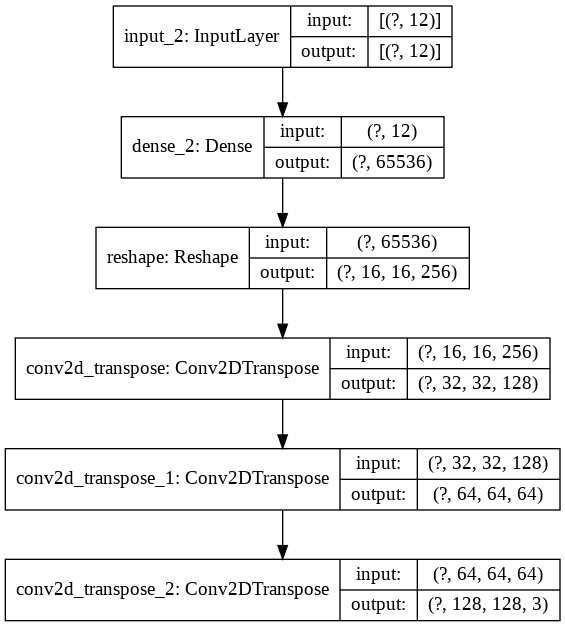

In [23]:
keras.utils.plot_model(variational_decoder, show_shapes=True)

In [24]:
codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * tf.math.reduce_sum(
    1 + codings_log_var - tf.math.exp(codings_log_var) - tf.math.square(codings_mean),
    axis=-1)

# divide by resized_image_dim * resized_image_dim * 3
variational_ae.add_loss(tf.math.reduce_mean(latent_loss) / (resized_image_dim * resized_image_dim * 3.))

variational_ae.compile(loss="binary_crossentropy", optimizer="nadam")

In [25]:
vae_train = ds_train.prefetch(1).shuffle(100).repeat().batch(BATCH_SIZE)
vae_valid = ds_valid.batch(BATCH_SIZE)

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00004)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

In [27]:
variational_ae.fit(vae_train, epochs=30, validation_data=vae_valid, callbacks=[reduce_lr, early_stopping_cb],
                   steps_per_epoch=int(ds_train_size / BATCH_SIZE), 
                   validation_steps=int(ds_validation_size / BATCH_SIZE))

Epoch 1/30
413/413 [==============================] - 18s 43ms/step - loss: 0.5733 - val_loss: 0.5579
Epoch 2/30
413/413 [==============================] - 18s 43ms/step - loss: 0.5537 - val_loss: 0.5548
Epoch 3/30
413/413 [==============================] - 18s 43ms/step - loss: 0.5517 - val_loss: 0.5517
Epoch 4/30
413/413 [==============================] - 18s 43ms/step - loss: 0.5502 - val_loss: 0.5509
Epoch 5/30
413/413 [==============================] - 18s 43ms/step - loss: 0.5487 - val_loss: 0.5497
Epoch 6/30
413/413 [==============================] - 18s 43ms/step - loss: 0.5479 - val_loss: 0.5493
Epoch 7/30
413/413 [==============================] - 18s 43ms/step - loss: 0.5471 - val_loss: 0.5488
Epoch 8/30
413/413 [==============================] - 18s 44ms/step - loss: 0.5465 - val_loss: 0.5495
Epoch 9/30
413/413 [==============================] - 18s 44ms/step - loss: 0.5461 - val_loss: 0.5478
Epoch 10/30
413/413 [==============================] - 18s 44ms/step - loss: 0.545

In [28]:
def display_ori_vs_reconstructed_images(model, dataset):
    """Displays three images and their reconstructions."""
    plt.figure(figsize=(6, 7))
    index = 1
    
    for image in dataset.shuffle(100).take(3):
        plt.subplot(3, 2, index)
        plt.axis("off")
        if index < 3:
            plt.title('Original')
        plt.imshow(image[0])
        index += 1
        plt.subplot(3, 2, index)
        #  we need the fourth, batch dimension for the model to predict 
        reconstructed_image = model.predict(tf.expand_dims(image[0], 0))
        plt.axis("off")
        plt.axis("off")
        if index < 3:
            plt.title('Reconstructed')
        plt.imshow(tf.reshape(reconstructed_image, image[0].shape)) # reshaping the reconstructed image back
        index += 1

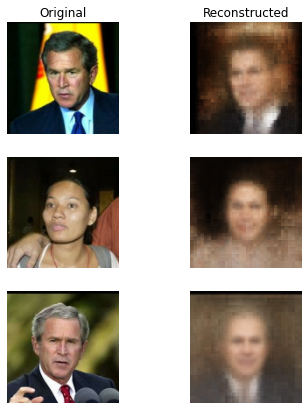

In [29]:
display_ori_vs_reconstructed_images(variational_ae, vae_valid.unbatch())

In [30]:
def generate_images(decoder):
    """Generates 20 images."""
    plt.figure(figsize=(10, 7))
    index = 1

    generated_codings = tf.random.normal(shape=[20, codings_size])
    images = decoder(generated_codings).numpy()
    for image in images:
        plt.subplot(4, 5, index)
        plt.axis("off")
        plt.imshow(image)
        plt.title(f'{index - 1}')
        index += 1
    return generated_codings

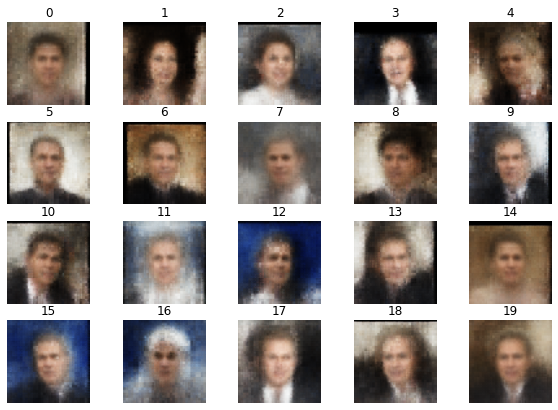

In [31]:
generated_codings = generate_images(variational_decoder)

We can now create new images by combining the codings.

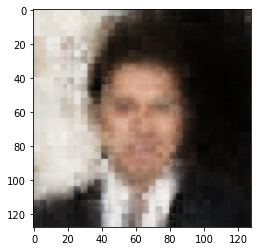

In [32]:
codings_combination = tf.reshape((generated_codings[8] + generated_codings[17]), [1, codings_size])

image = tf.reshape(variational_decoder(codings_combination), [128, 128, 3])
plt.imshow(image);

The images are quite blurry, which is a known problem with VAEs. Increasing the size of the codings vector will only make things worse, since then the VAE will pay more attention to the image backgrounds, leading to images with even more blurry faces.

# Etude 3 - Training a GAN

Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class.

In [33]:
codings_size = 15

generator = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 256]),
    # keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same",
                                 activation="relu"),
    # keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same",
                                 activation="relu"),
    # keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same",
                                 activation="tanh")    
])

discriminator = keras.models.Sequential([
    keras.layers.Input(shape=(128, 128, 3)),
    # rescaling the image via lambda layer did not work for some reason:
    # the images lacked deep blacks
    # keras.layers.Lambda(lambda x: x * 2. - 1.), # rescales to [-1, 1] since we use tanh
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU()),
    # keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU()),
    # keras.layers.Dropout(0.2),
    keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU()),
    # keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [34]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [35]:
# keras.utils.plot_model(generator, show_shapes=True)

Now let's create the tranining loop with the optional experience replay.


In [36]:
def train_gan(gan, dataset, batch_size, codings_size, experience_replay_buffer=2, n_epochs=12):
    """"Trains the GAN. To disable the experience replay,
    use experience_replay_buffer=0; otherwise, specify the number 
    of iterations to keep in the buffer."""
    generator, discriminator = gan.layers
    buffer = tf.queue.FIFOQueue(experience_replay_buffer, 
                                shapes=(batch_size, resized_image_dim, resized_image_dim, 3), 
                                dtypes=tf.float32)
    for epoch in range(n_epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # Discriminator training
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            
            if experience_replay_buffer == 0:
                X_fake_and_real = tf.concat([generated_images, X_batch[0]], axis=0) # Do we even need labels to use [0]?                
            else:
                if buffer.size() < experience_replay_buffer:
                    buffer.enqueue(generated_images)
                    X_fake_and_real = tf.concat([generated_images, X_batch[0]], axis=0)                    
                else:   
                    X_fake_and_real = tf.concat([buffer.dequeue(), X_batch[0]], axis=0)
                    buffer.enqueue(generated_images)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Generator training
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        print('  Time (sec): {}'.format(round(time.time()-start)))

In [37]:
gan_train = ds_train.map(lambda x, y: (x * 2. - 1., y))
gan_train = gan_train.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [38]:
train_gan(gan, gan_train, BATCH_SIZE, codings_size, experience_replay_buffer=0)

Epoch 1/12
  Time (sec): 44
Epoch 2/12
  Time (sec): 42
Epoch 3/12
  Time (sec): 42
Epoch 4/12
  Time (sec): 43
Epoch 5/12
  Time (sec): 42
Epoch 6/12
  Time (sec): 42
Epoch 7/12
  Time (sec): 43
Epoch 8/12
  Time (sec): 43
Epoch 9/12
  Time (sec): 42
Epoch 10/12
  Time (sec): 42
Epoch 11/12
  Time (sec): 42
Epoch 12/12
  Time (sec): 42


In [39]:
def generate_images_gan(decoder):
    """Generates 20 images."""
    plt.figure(figsize=(10, 7))
    index = 1

    generated_codings = tf.random.normal(shape=[20, codings_size], seed=42)
    images = decoder(generated_codings).numpy()
    images = (images + 1.) / 2. # rescale back to [0, 1]
    for image in images:
        plt.subplot(4, 5, index)
        plt.axis("off")
        plt.imshow(image)
        plt.title(f'{index - 1}')
        index += 1    

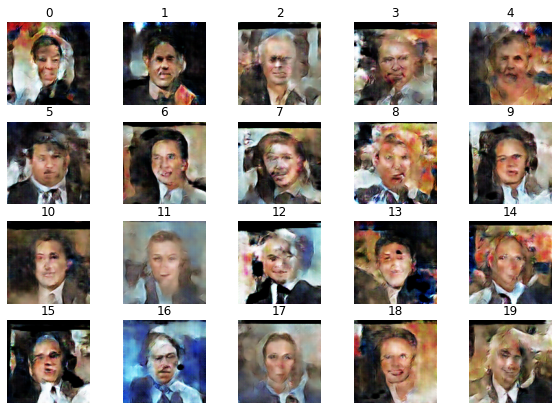

In [40]:
generate_images_gan(generator)

# Etude 4 - Training a Conditional GAN

Since the "Labeled Faces in the Wild" dataset do not have enough images in each class, let's create a conditional GAN using a better suited Fashion-MNIST dataset. 

In [41]:
fashion_mnist, fashion_mnist_info = tfds.load("fashion_mnist:3.*.*", with_info=True, as_supervised=True, split="test+train")

In [42]:
def visualize_dataset(dataset):
    """Visualizes several dataset images."""
    plt.figure(figsize=(5, 5))
    index = 0
    for item in dataset.take(6):
        index += 1
        plt.suptitle('Original')
        plt.subplot(2, 3, index)
        plt.imshow(tf.reshape(item[0], [28, 28]), cmap='binary')
        
        plt.axis("off")
    plt.show()

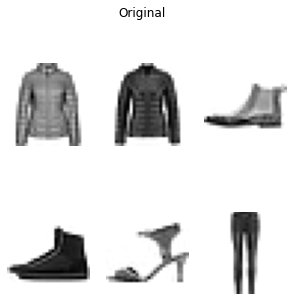

In [43]:
visualize_dataset(fashion_mnist)

Now let's preprocess the images. Since we use the tanh activation function in the generator, we need to rescale them to [1, 1].

In [44]:
def preprocess_mnist(image, label):
    """Rescaling the dataset to [-1, 1]"""
    image = tf.cast(image, tf.float32) / 255.0
    image = image * 2. - 1.
    # return image
    return image, label

In [45]:
fashion_mnist = fashion_mnist.map(preprocess_mnist)

Now let's select the size of the latent dimenstion. Unlike in autoencoders where the latent space can be quite small, in GANs it should be much larger; otherwise, the generated images will be unrecognizable.

In [46]:
codings_size = 150

Now let's built the generator and discriminator networks. Image labels are added together with the codings. We also apply the one-hot-encoding to labels; otherwise, GAN would not be able to generate consistent classes for a given class.

In [47]:
# Generator
## inputs
input_codings = keras.layers.Input(shape=(codings_size))
input_class_g = keras.layers.Input(shape=(1,), dtype="int64")

## dense layers - class
one_hot_g = keras.layers.Lambda(lambda label: tf.one_hot(label, 10))(input_class_g)
g_class1 = keras.layers.Dense(7 * 7 * 1)(one_hot_g)
g_reshape_class = keras.layers.Reshape([7, 7, 1])(g_class1)

## dense layers - generator
g_dense1 = keras.layers.Dense(7 * 7 * 128)(input_codings)
g_reshape = keras.layers.Reshape([7, 7, 128])(g_dense1)

g_concat = keras.layers.Concatenate()([g_reshape, g_reshape_class])

g_bn1 = keras.layers.BatchNormalization()(g_concat)
g_dense2 = keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same",
                                 activation="relu")(g_bn1)
g_bn2 = keras.layers.BatchNormalization()(g_dense2)
g_dense3 = keras.layers.Conv2DTranspose(64, kernel_size=4, strides=1, padding="same",
                                 activation="relu")(g_bn2)
## output
g_bn3 = keras.layers.BatchNormalization()(g_dense3)
g_output = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                 activation="tanh")(g_bn3)

# Discriminator
## inputs
input_im = keras.layers.Input(shape=(28, 28, 1))
input_class_d = keras.layers.Input(shape=(1,), dtype="int64")

## dense layers - class
one_hot_d = keras.layers.Lambda(lambda label: tf.one_hot(label, 10))(input_class_d)
d_class1 = keras.layers.Dense(28 * 28 * 1)(one_hot_d)
d_reshape_class = keras.layers.Reshape([28, 28, 1])(d_class1)

## dense layers
d_concat = keras.layers.Concatenate()([input_im, d_reshape_class])
d_dense1 = keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same",
                               activation=tf.keras.layers.LeakyReLU())(d_concat)
d_drop1 = keras.layers.Dropout(0.4)(d_dense1)
d_dense2 = keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU())(d_drop1)
d_drop2 = keras.layers.Dropout(0.4)(d_dense2)
d_flatten = keras.layers.Flatten()(d_drop2)
## output
d_output = keras.layers.Dense(1, activation="sigmoid")(d_flatten)

Now let's build the generator model (no need to complile it, though).

In [48]:
generator_mn = keras.Model(inputs=[input_codings, input_class_g], outputs=g_output)

Similarly, let's build the discriminator model.

In [49]:
discriminator_mn = keras.Model(inputs=[input_im, input_class_d], outputs=d_output)
discriminator_mn.compile(loss="binary_crossentropy", optimizer="adam")
discriminator_mn.trainable = False

Finally, let's build the GAN model. Note that the GAN output is specified as the output of the descriminator, that, in its turn, received the generator output as input.

In [50]:
# generator inputs and output
generator_output = generator_mn.output
gan_output = discriminator_mn([generator_output, input_class_g]) 

gan_mnist = keras.Model(inputs=[input_codings, input_class_g], outputs=gan_output)
gan_mnist.compile(loss="binary_crossentropy", optimizer="adam")

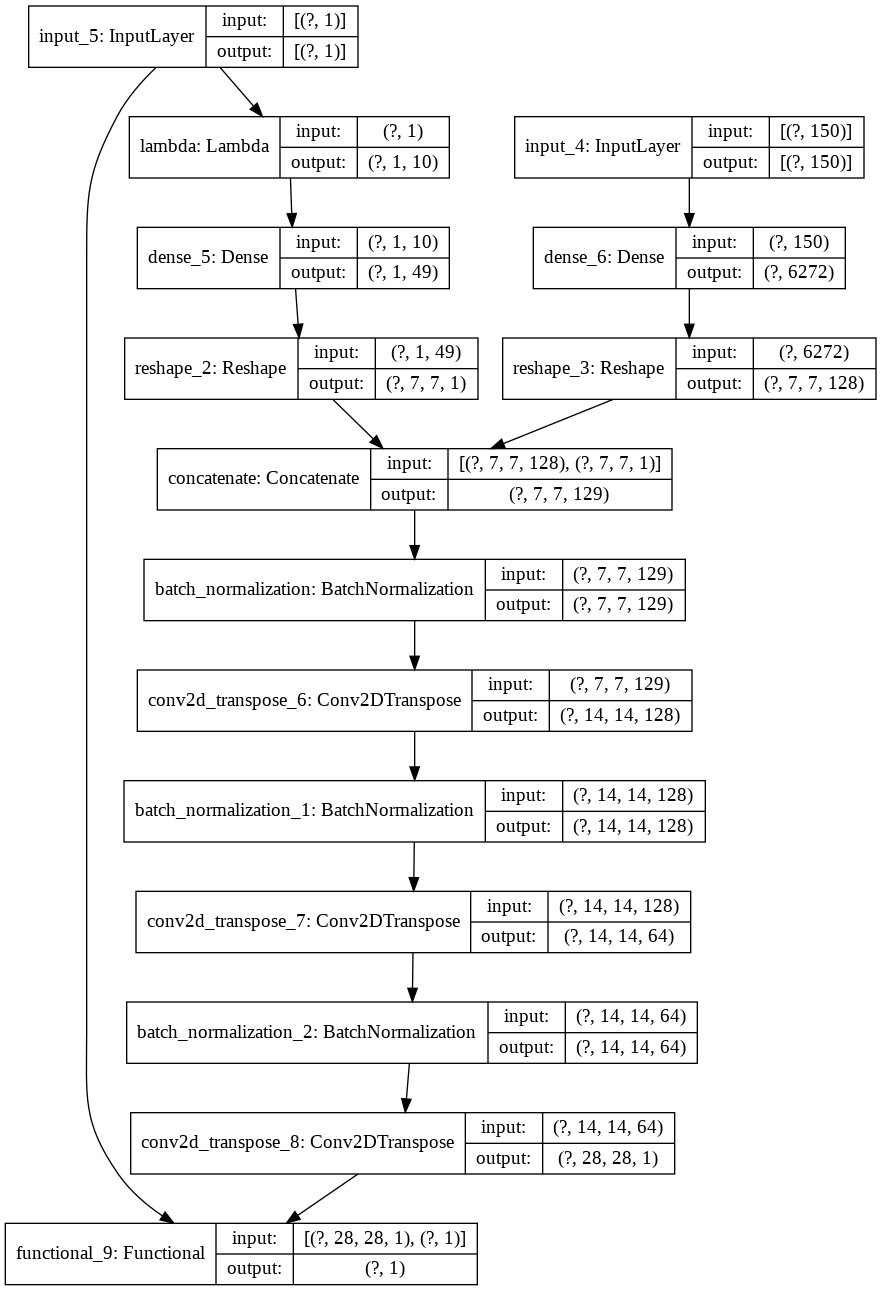

In [51]:
keras.utils.plot_model(gan_mnist, show_shapes=True)

Now let's write a train function. We generate random noise and random labels and pass them to the generator. Then the images produced by the generator together with the fake labels are concatenated with real images and real labels. Then, together with the targer vector, they are passed to the discriminator.
Then, during the generator training, we again create noise and fake labels and pass them to the GAN togerther with the targer vector that tells GAN that all these data are true.

In [52]:
def train_gan_mnist(gan, discriminator, generator, dataset, batch_size, codings_size, n_epochs=10):
    for epoch in range(n_epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # Discriminator training
            noise = tf.random.normal(shape=[batch_size, codings_size])
            random_classes = tf.random.uniform(shape=[batch_size, 1], dtype=tf.int32, minval=0, maxval=10)
            random_classes = tf.cast(random_classes, tf.float32)
            generated_images = generator([noise, random_classes]) 
            X_fake_and_real = tf.concat([generated_images, X_batch[0]], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) 
            y1_labels = tf.concat([random_classes, tf.reshape(tf.cast(X_batch[1], tf.float32), [batch_size, 1])], 0)            
            discriminator.trainable = True
            discriminator.train_on_batch([X_fake_and_real, y1_labels], y1)
            
            # Generator training
            noise = tf.random.normal(shape=[batch_size, codings_size])
            random_classes = tf.random.uniform(shape=[batch_size, 1], dtype=tf.int32, minval=0, maxval=10)
            random_classes = tf.cast(random_classes, tf.float32)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch([noise, random_classes], y2)
        print('  Time (sec): {}'.format(round(time.time()-start)))

In [53]:
gan_train_mnist = fashion_mnist.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [54]:
train_gan_mnist(gan_mnist, discriminator_mn, generator_mn, gan_train_mnist, BATCH_SIZE, codings_size, n_epochs=12)

Epoch 1/12
  Time (sec): 66
Epoch 2/12
  Time (sec): 64
Epoch 3/12
  Time (sec): 64
Epoch 4/12
  Time (sec): 64
Epoch 5/12
  Time (sec): 64
Epoch 6/12
  Time (sec): 66
Epoch 7/12
  Time (sec): 65
Epoch 8/12
  Time (sec): 65
Epoch 9/12
  Time (sec): 66
Epoch 10/12
  Time (sec): 66
Epoch 11/12
  Time (sec): 67
Epoch 12/12
  Time (sec): 67


In [55]:
def generate_images_gan_mnist(decoder, label):
    """Generates 6 images."""
    plt.figure(figsize=(5, 5))
    index = 1

    label = tf.constant([[label]] * 6)
    generated_codings = tf.random.normal(shape=[6, codings_size])
    images = decoder([generated_codings, label]).numpy()
    images = (images + 1.) / 2. # rescale back to [0, 1]
    for image in images:
        plt.suptitle('Generated')
        plt.subplot(2, 3, index)
        plt.axis("off")
        plt.imshow(tf.squeeze(image), cmap='binary')        
        index += 1

In [56]:
def compare_samples(class_n):
    """"Compares real and generated samples."""
    visualize_dataset(fashion_mnist.filter(lambda x, y: y == class_n))
    generate_images_gan_mnist(generator_mn, class_n)

Let's compare the real and generated samples of the given class (we have 10 classes total).

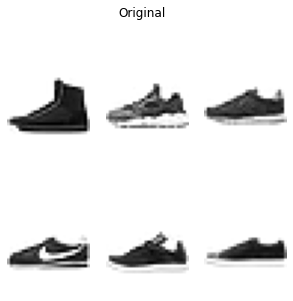

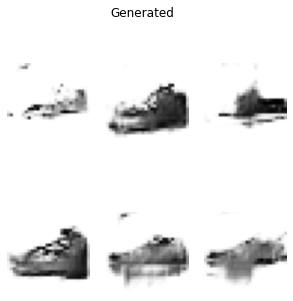

In [57]:
compare_samples(7)